# Part 4 - Application example: Receptive field reconstruction

This session is concerned with how one can apply the concepts introduced in this course to create something of scientific value. Many examples could be picked for that since spiketrain modeling is a pretty fundamental task in neuroscience, but here we will walk through a method for measuring neural receptive fields, introduced by Pipa et al. in the 2012 paper [Precise mapping of V1 receptive fields by tomographic reconstruction](http://www.mitpressjournals.org/doi/abs/10.1162/NECO_a_00334). At the heart of the method lies a generalized linear model of spiking probabilities similar to the ones introduced before.


* **Task 1:** Read the paper! But imagine that you only have 30 minutes and need to limit yourself these parts:
    * Abstract
    * Introduction
    * before you go on: Have a look at this [somewhat intuitive description of the Radon transform](http://homepages.inf.ed.ac.uk/rbf/CVonline/LOCAL_COPIES/AV0405/HAYDEN/Slice_Reconstruction.html)
    * First two paragraphs of Methods
    * Figure 5 -- shows what it is all about, from spiketrain modelling to receptive field
    * Figure 9 -- shows that this also works for receptive fields with more complicated structure.
    


**Hint: This notebook is a bit different from the previous ones -- there's less programming, more staring at graphs. It's also intended to be a short one: No need to spend the whole day on it. Except if you feel like it.**

In [ ]:
from matplotlib.pyplot import *
%matplotlib inline
import numpy as np
import splines
from skimage.transform.radon_transform import radon,iradon
from scipy.ndimage.filters import gaussian_filter1d

In [1]:
def reduce_resolution(array,factor,sum_spikes=True):
    """ 
    Reduces the temporal resolution of an array of spike trains.
    
    This can cause multiple spikes to fall into one time bin, i.e. the
    returned array can contain integers > 1.
    If sum_spikes is set to False, we do not sum spike counts. Instead,
    any spike counts > 1 in one bin are truncated down to 1. In that case,
    a binary array is returned, but some spikes may be lost.
    
    Arguments:
        array: 4D numpy array. Reduction will occur along the last dimension (T).
        factor: integer to divide the number of time bins by.
        sum_spikes: If false, truncate the number of spikes per bin to 1.
      
    Returns:
        4D numpy array, similar as input but last dimension with length T/factor.
    """
    assert type(factor) is int
    reduced_shape = (array.shape[0],array.shape[1],array.shape[2],array.shape[3]/np.round(factor))
    spikes_reduced = np.zeros(reduced_shape) # create a shortened result array
    for idx in np.ndindex(array.shape[0:3]): # for all indices along the first 3 dimensions..
        spiketimes = (array[idx].nonzero()[0] / factor).astype(int) # get spiketimes, divide by factor
        for spiketime in spiketimes[spiketimes<spikes_reduced.shape[-1]]: # loop manually, since numpy indexing treats index lists as sets
            spikes_reduced[idx[0],idx[1],idx[2],spiketime] += 1 # increment result array by 1 at the divided spiketimes
    
    if not sum_spikes:
        spikes_reduced  = spikes_reduced >= 1
    spikecount_difference = (np.sum(array) - np.sum(spikes_reduced)).astype(int)
    if spikecount_difference > 0:
        print "Lost "+str(spikecount_difference)+" spikes through resolution reduction."
    return spikes_reduced    

def find_percentiles(y, num_percentiles, return_thresholds=False):
    """ Finds `num_percentiles` equally spaced percentiles of `y` (a monotonically increasing vector),
    i.e. it approximates the inverse `x` of the function `y=f(x)` 
    at `num_percentiles` equally spaced `y`-values between 0 and `y[-1]`.
    
    Arguments:
        y:                  a sequence of monotonically increasing function values
        num_percentiles:    number of percentiles to find between 0 and `y[-1]`.
        return_threshold:   boolean value to indicated whether or not to return the thresholds, too
    Returns:
        percentiles:        `y`-values of the percentiles
        [thresholds:        `x`-values of the percentiles]
    """
    thresholds = np.linspace(0,y[-1],num_percentiles+1)
    percentiles = np.zeros_like(thresholds)
    
    current = 1
    for step in range(T):
        if y[step] > thresholds[current]:
            percentiles[current] = step
            current +=1
    
    percentiles[-1] = len(y)
    if return_thresholds:
        return percentiles, thresholds
    else:
        return percentiles

# Load the data:
with np.load('data_movingbar_c16.npz') as archive:
    original_spikes = archive['spikes_movingbar']
    

# reduce resolution:
resolution_reduction = 20 # <-- resolution reduction factor
spikes = reduce_resolution(original_spikes,factor=resolution_reduction, sum_spikes=True)
    
n_conditions = spikes.shape[1]
N = spikes.shape[2] # number of trials
T = spikes.shape[3] # length of a trial

# Radon transform and back (toy example)

Since you have read the paper and looked at this [relatively more intuitive description of the Radon transform](http://homepages.inf.ed.ac.uk/rbf/CVonline/LOCAL_COPIES/AV0405/HAYDEN/Slice_Reconstruction.html) for a few minutes, you will now have a rough understanding of the transform and the aims of the paper. So here is an example of the radon transform and its inverse operation in action, which will hopefully solidify these intuitions.

(Run the next cell, text continues after the plots)

<matplotlib.colorbar.Colorbar instance at 0x12d2c9b00>

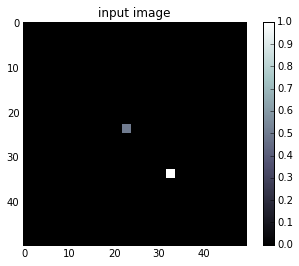

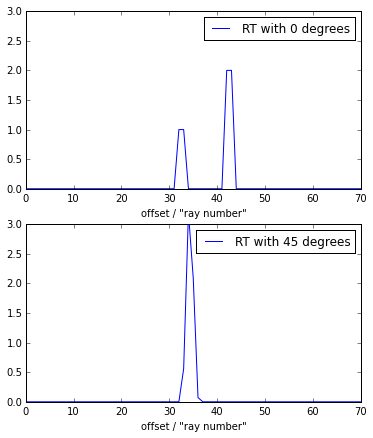

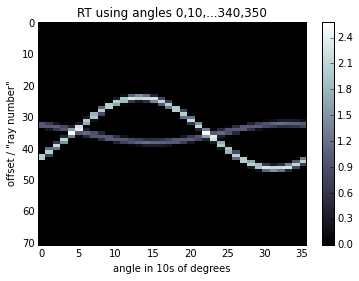

In [92]:
bla = np.zeros((50,50))
bla[33,32] = 1
bla[33,33] = 1
bla[34,32] = 1
bla[34,33] = 1

bla[23,22] = 0.5
bla[23,23] = 0.5
bla[24,22] = 0.5
bla[24,23] = 0.5

figure()
imshow(bla,interpolation='nearest',cmap='bone')
title("input image")
colorbar()
# --- 

from skimage.transform.radon_transform import radon,iradon

figure(figsize=(6,7))
subplot(2,1,1)
plot(radon(bla,[0]),label="RT with 0 degrees")
xlab
We have a simple image that contains a white dot and a grey dot.

Keeping the notation of the linked description, we now apply the $R_0$ radon transform to this image. Imagine a series of parallel "rays" transsecting the image from the bottom to the top, adding up all image elements they encounter on the way. It shouldn't be surprising that the result is a 1D vector with a small bump and a higher bump. We then do the same for another angle ($R_45$): Now, imagine a series of parallel "rays" starting from the bottom right corner, adding up all image elements they encounter on the way to the top left. The resulting 1D vector has just one bump, its height the sum of the two bumps we saw before.


We then run a Radon transform with all angles 0 to 360 in steps of 10, and plot the resulting series of 36 1D vectors as an image.
We have a simple image that contains a white dot and a grey dot.

Keeping the notation of the linked description, we now apply the $R_0$ radon transform to this image. Imagine a series of parallel "rays" transsecting the image from the bottom to the top, adding up all image elements they encounter on the way. It shouldn't be surprising that the result is a 1D vector with a small bump and a higher bump. We then do the same for another angle ($R_45$): Now, imagine a series of parallel "rays" starting from the bottom right corner, adding up all image elements they encounter on the way to the top left. The resulting 1D vector has just one bump, its height the sum of the two bumps we saw before.


We then run a Radon transform with all angles 0 to 360 in steps of 10, and plot the resulting series of 36 1D vectors as an image.el('offset / "ray number"')
ylim(0,3)
legend()
subplot(2,1,2)
plot(radon(bla,[45]),label="RT with 45 degrees")
xlabel('offset / "ray number"')
ylim(0,3)
legend()

figure()
radon_image = radon(bla,np.arange(0,360,10))
imshow(radon_image,aspect='auto',interpolation='nearest',cmap='bone')
title("RT using angles 0,10,...340,350")
xlabel("angle in 10s of degrees")
ylabel('offset / "ray number"')
colorbar()

We have a simple image that contains a white dot and a grey dot (Top plot).

Keeping the notation of the linked description, we now apply the $R_0$ radon transform to this image. Imagine a series of parallel "rays" transsecting the image from the bottom to the top, adding up all image elements they encounter on the way. It shouldn't be surprising that the result is a 1D vector with a small bump and a higher bump (middle plot). We then do the same for another angle ($R_45$): Now, imagine a series of parallel "rays" starting from the bottom right corner, adding up all image elements they encounter on the way to the top left. The resulting 1D vector has just one bump, its height the sum of the two bumps we saw before (middle plot, 2nd panel).

Finally, we run a Radon transform with all angles 0 to 360 in steps of 10, and plot the resulting series of 36 1D vectors as an array (bottom plot). If we would plot columns 0 and 5 of that array, they would look like the two line plots above.

## What this has to do with moving bars and receptive fields

The paper proposes that the same process as just described happens when a visual cortex neuron sees a moving bar crossing through its receptive field: The bar has some angle, and, at each position along its way through the visual field, evokes a neural reaction that reflects its summed influence under the neuron's receptive field. So, to spell out the analogies: The image is the neuron's receptive field. The different parallel "rays" (offset) are the positions of the moving bar at different points in time. The angle at which the Radon transform is applied is the angle of the direction in which the bar moves. For each particular angle, the 1D vector that results from the transform is the neuron's changing spike response over time.

Now, we will use our GLM tools to model the changing spike responses over time of a neuron that was presented with moving bars at different angles. By the above, we treat this as a Radon-transformed version of the neuron's recepive field. Then we apply the inverse transform to the model outputs, to get a estimate of the neuron's receptive field.

We didn't yet explain the inverse radon transform. All we'll say is it takes an array of "summed up", radon-transformed data as in the last plot above, and reconstructs the original image from it. This only works if we supply the information which column in that array is the result of a Radon transform with which angle. See these plots:

<matplotlib.colorbar.Colorbar instance at 0x132b54878>

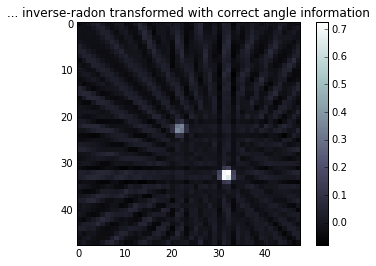

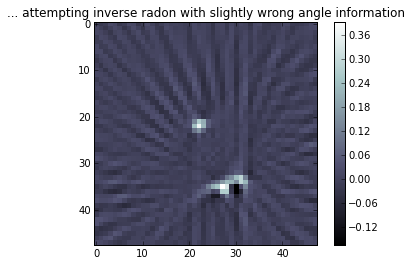

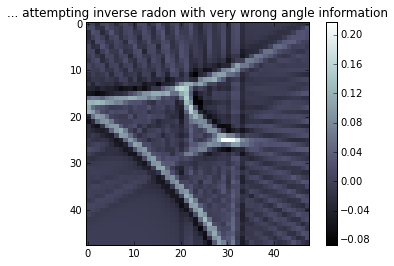

In [93]:
figure()
f = iradon(radon_image, 360*np.arange(0,n_conditions)/n_conditions) # solution
imshow(f[1:-1,1:-1],interpolation='nearest',cmap='bone')
title("... inverse-radon transformed with correct angle information")
colorbar()


figure()
f = iradon(radon_image, 321*np.arange(0,n_conditions)/n_conditions) # solution
imshow(f[1:-1,1:-1],interpolation='nearest',cmap='bone')
title("... attempting inverse radon with slightly wrong angle information")
colorbar()


figure()
f = iradon(radon_image, 123*np.arange(0,n_conditions)/n_conditions) # solution
imshow(f[1:-1,1:-1],interpolation='nearest',cmap='bone')
title("... attempting inverse radon with very wrong angle information")
colorbar()

## Model fitting

As mentioned, we have 36 stimulus conditions (one for each moving bar angle), so we want to create 36 models. For this, we should pack our familiar model fitting code into functions.

Below, we define a few helper functions that you will find familiar. Then we define a function that takes spike data from one condition (N trials of duration T), fits a simple time-dependent spline model and returns its prediction (i.e. a series of spike probabilities for each time step in $(0,T)$). If you look at that function, you will find nothing that you didn't see in Part 2 already.

In [ ]:
import statsmodels.api as sm

def get_dm_rate(summed_spikecount):
    """get the purely temporal components of the dm"""
    num_knots = 16
    spline_order = 3
    sigma = 100/resolution_reduction
    cumulative = np.cumsum(np.abs(gaussian_filter1d(summed_spikecount, sigma=sigma, order=0)))
    knots   = find_percentiles(cumulative, num_knots)
    knots = splines.augknt(knots, spline_order)
    return np.array(splines.spcol(range(T),knots,spline_order))
  

def get_hist_bases():
    """get basis functions / kernels (for convolution)"""    
    history_length = 100/resolution_reduction
    history_spline_order = 3                          
    history_num_knots = 4       
    
    history_knots = splines.augknt(np.logspace(0,np.log10(history_length),history_num_knots),history_spline_order)
    history_knots = history_knots[:-1]

    history_x = np.linspace(1+1e-10,history_length,history_length)                                 
    return splines.spcol(history_x,history_knots,history_spline_order)
    

def get_dm_ahist(spiketrain):
    """get the auto history components of the dm"""
    hist_bases = get_hist_bases()
    num_history_bases = hist_bases.shape[1]
    hist_cell_dm = np.zeros((len(spiketrain),num_history_bases))    
    for i in range(num_history_bases):
        padded_kernel = np.hstack([np.zeros_like(hist_bases[:,i]),hist_bases[:,i]])
        hist_cell_dm[:,i] = np.convolve(spiketrain, padded_kernel, "same")
    return hist_cell_dm

def fit_rate_only(spikes_singlecondition):
    """fit a model with just temporal components on the given spike data"""    
    assert spikes_singlecondition.shape == (N,T)
    sigma = 100/resolution_reduction
    summed_spikecount = np.sum(spikes_singlecondition,axis=0)
    dm = get_dm_rate(summed_spikecount)
    spikes_nospikes = np.vstack([summed_spikecount, N*resolution_reduction-summed_spikecount]).T    
    model = sm.GLM(spikes_nospikes,dm,family=sm.families.Binomial())
    fitted_model = model.fit()
    prediction = fitted_model.predict(dm)
    prediction[0] = 0
    return prediction


preds_rate = []
for i in range(n_conditions):
    preds_rate.append(fit_rate_only(spikes[0,i,:,:]))

Now for something slightly less familiar. The paper pulls the following trick: They fit a model with both a rate component and, now, also an auto-history component (as we did in part 3). Then, they create prediction using only the rate basis functions, zeroing out the remaining (auto-history-related) columns of the design matrix. Why would this prediction be different from the previous model, which already only contained rate components? It seems that these features are not orthogonal, that is: Some patterns in the data are explained away by history features, allowing a different fit of the remaining (rate) components. Perhaps the predictions of this model can be interpreted as how much the neuron would "want" to fire if it weren't for the refractory period. Anyway, here is how this can be implemented:

In [5]:
def fit_rate_absorb_history(spikes_singlecondition):
    assert spikes_singlecondition.shape == (N,T)
    spline_order = 3
    summed_spikecount = np.sum(spikes_singlecondition,axis=0)
    chained_trials = spikes_singlecondition.ravel()
    dm_ahist = get_dm_ahist(chained_trials)
    num_history_bases = dm_ahist_.shape[1]
    dm_rate = get_dm_rate(summed_spikecount)
    dm = np.hstack([dm_ahist,np.tile(dm_rate_,(N,1))])

    spikes_nospikes = np.vstack([chained_trials, resolution_reduction-chained_trials]).T    
    model = sm.GLM(spikes_nospikes,dm,family=sm.families.Binomial())
    fitted_model = model.fit()
    # # explicit version:
    # rateparams = fitted_model.params[num_history_bases:]
    # eta_rate = np.dot(dm_rate_,rateparams)
    # prediction = 1/(1+np.exp(-eta_rate))
    # # -> equivalent to zeroing the respective DM columns:
    prediction = fitted_model.predict(np.hstack([np.zeros((T,num_history_bases)),dm_rate]))
    prediction[0] = 0
    return prediction


    
preds_rate_absorb_history = []
for i in range(n_conditions):
    preds_rate_absorb_history.append(fit_rate_absorb_history(spikes[0,i,:,:]))

# Figure 5

Remember Figure 5 in the papar?

(execute the next cell for plots)

As you can see, the spike rate peaks at different points in time in different conditions (different bar angles). That's not surprising: As long as the neuron's receptive field isn't right in the middle of the visual field, the bar will pass through the center the receptive field at different times depending on the direction it's moving.

You can also see that the rate models with "absorbed" history effects have different fits from the pure rate model, estimating a slightly higher overall probability and, in some cases, sharper peaks.

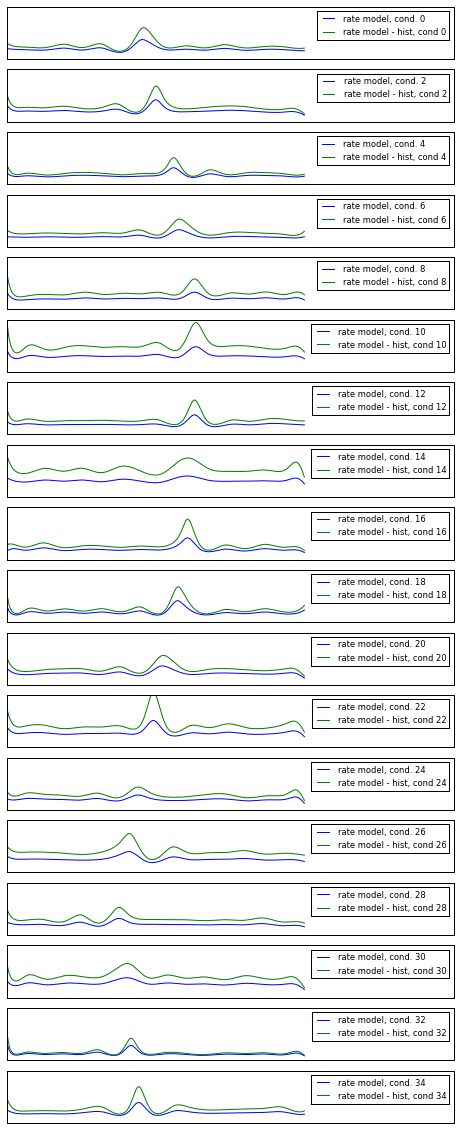

In [81]:
figure(figsize=(8,20))
for i in range(0,n_conditions,2):
    subplot(n_conditions/2,1,i/2+1)
    plot(preds_rate[i],label='rate model, cond. '+str(i))
    plot(preds_rate_absorb_history[i],label='rate model - hist, cond '+str(i))    
    xlim((0,T*1.5))
    ylim(0,0.025)
    legend(fontsize='small')
    if i != n_conditions-1:
        xticks([])
        yticks([])
    else:
        xlabel("time step")
        ylabel("p")

We now stack these estimaes into two arrays (one for each of the two model types) and apply the inverse Radon transform. The arrays and the result of the inversion are shown below:

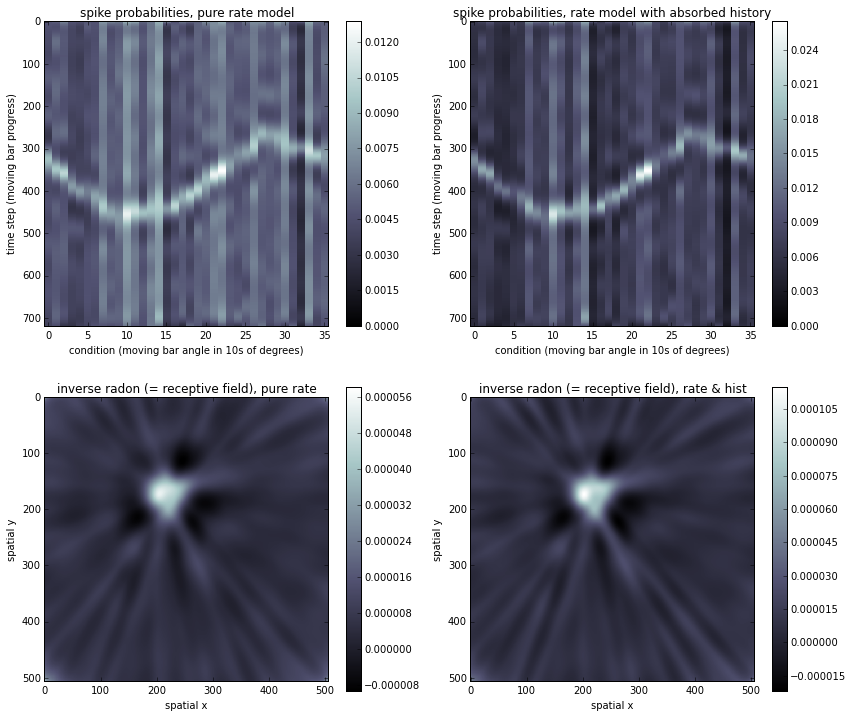

In [76]:
radonimage_rate = np.array(preds_rate).T
radonimage_rate_absorb_hist = np.array(preds_rate_absorb_history).T

figure(figsize=(14,12))

# only rate based
subplot(2,2,1)
title("spike probabilities, pure rate model")
imshow(radonimage_rate,aspect='auto',interpolation='nearest',cmap='bone')
ylabel("time step (moving bar progress)")
xlabel("condition (moving bar angle in 10s of degrees)")
colorbar()

subplot(2,2,3)
title("inverse radon (= receptive field), pure rate")
f = iradon(radonimage_rate, 360*np.arange(0,n_conditions)/n_conditions)
imshow(f[1:-1,1:-1],interpolation='nearest',cmap='bone')
colorbar()
xlabel("spatial x")
ylabel("spatial y")

# rate & absorb history
subplot(2,2,2)
title("spike probabilities, rate model with absorbed history")
imshow(radonimage_rate_absorb_hist,aspect='auto',interpolation='nearest',cmap='bone')
ylabel("time step (moving bar progress)")
xlabel("condition (moving bar angle in 10s of degrees)")
colorbar()

subplot(2,2,4)
title("inverse radon (= receptive field), rate & hist")
f = iradon(radonimage_rate_absorb_hist, 360*np.arange(0,n_conditions)/n_conditions)
imshow(f[1:-1,1:-1],interpolation='nearest',cmap='bone')
colorbar()
xlabel("spatial x")
ylabel("spatial y")

**We arrived at an estimation of the position and shape of the neuron's receptive field.**

The difference between the two model types is not too vast, but one might call the right picture a bit more "sharp".